In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import figure, format_plots, PlotConfig

In [2]:
format_plots()
c = PlotConfig()

In [3]:
def minmax(df):
    df = df - df.min()
    return df / df.max()

In [4]:
syllable_classes = pd.read_csv('./v11_syllable_labels_v2.csv')

In [5]:
id_map = syllable_classes.set_index('Original ID')['Class']

In [6]:
colors = ['#c7eae5','#008C8D']
male_cmap = sns.blend_palette(colors, as_cmap=True)
colors = ['#fee6ce','#d94801']
female_cmap = sns.blend_palette(colors, as_cmap=True)

In [7]:
cmapmap = {
    'ont_males': male_cmap,
    'ont_females': female_cmap,
    'long_v2_male': male_cmap,
    'long_v2_female': female_cmap,
}

In [8]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)
df = df[keep_syllables]
df['exp'] = 'ont_males'
df = df.set_index('exp', append=True)
# df = minmax(df)

In [9]:
class_sort = [id_map[k] for k in df.columns]

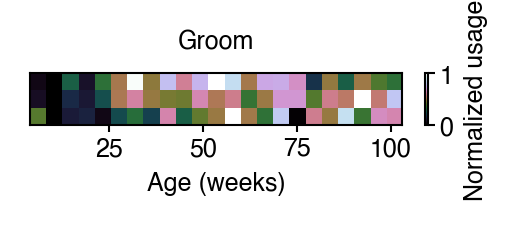

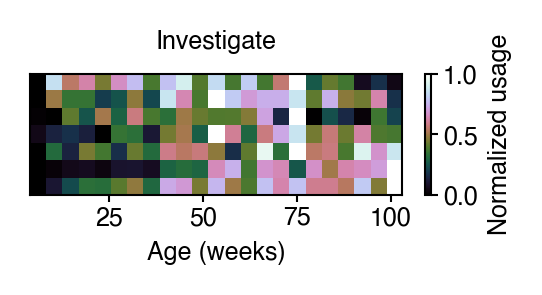

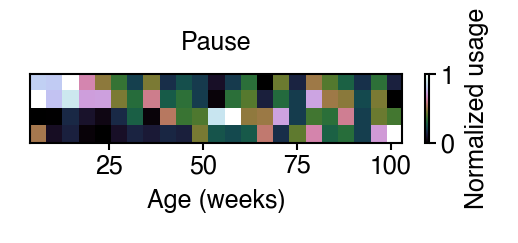

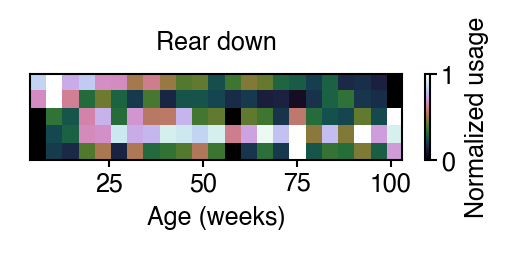

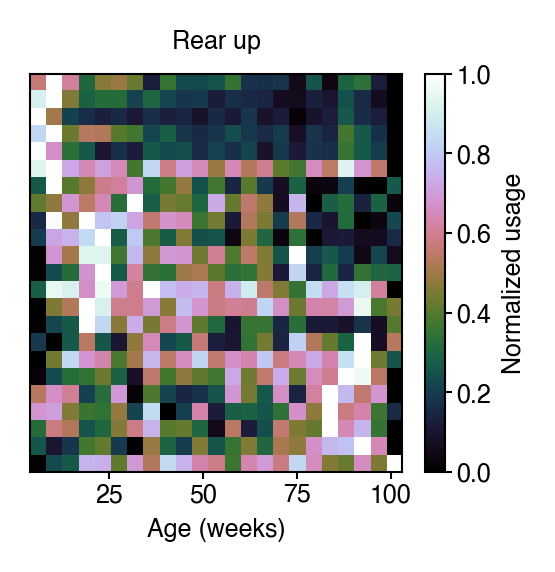

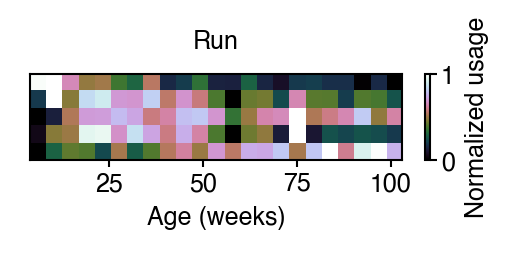

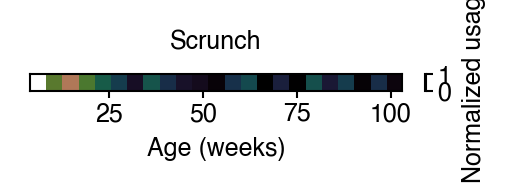

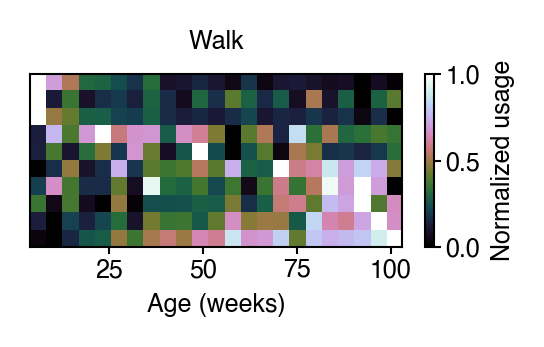

In [10]:
class_avgs = {}
class_norm_avgs = {}
for _class, _df in df.T.groupby(class_sort):
    avgs = _df.T.groupby('age').mean()
    class_avgs[_class] = avgs.mean(1)

    norm_avgs = minmax(avgs)

    peaks = (
        norm_avgs.rolling(7, min_periods=1, center=True, win_type="exponential")
        .mean(tau=3)
        .idxmax()
    )
    peaks = peaks.sort_values()
    class_norm_avgs[_class] = norm_avgs.mean(1)

    ages = avgs.index

    fig = figure(2, 0.075 * avgs.shape[1])
    plt.imshow(norm_avgs[peaks.index].T, cmap='cubehelix', extent=(ages[0], ages[-1], avgs.shape[1], 0), aspect='auto')
    plt.title(_class)
    plt.colorbar(label="Normalized usage")
    plt.yticks([])
    plt.xlabel("Age (weeks)")
    #sns.despine()
    fig.savefig(c.dana_save_path / "fig2"/ f'male_class-{_class}.pdf')
    

In [11]:
class_df = pd.DataFrame(class_norm_avgs)
peaks = (
    class_df.rolling(7, min_periods=1, center=True, win_type="exponential")
    .mean(tau=3)
    .idxmax()
)
peaks = peaks.sort_values()

In [12]:
col_order = ['Pause', 'Scrunch', 'Groom', 'Rear down','Rear up','Run','Investigate','Walk']
class_df_new = class_df.reindex(columns=col_order)

<Axes: xlabel='age'>

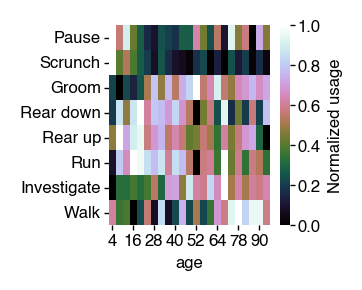

In [13]:
format_plots()
fig, ax = plt.subplots(figsize=(1.3, 1.3))
sns.heatmap(minmax(class_df_new).T, cmap='cubehelix', vmax=1, cbar_kws=dict(label='Normalized usage'))

<Axes: xlabel='age'>

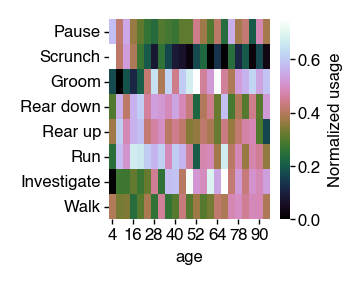

In [14]:
format_plots()
fig, ax = plt.subplots(figsize=(1.3, 1.3))
sns.heatmap(class_df_new.T, cmap='cubehelix', vmax=0.75, cbar_kws=dict(label='Normalized usage'))

In [15]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig2"/ 'male_syll_clusters_avg.pdf')